In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# Paths to the main dataset and the splits
train_dir = '/content/drive/MyDrive/Dataset/Train'
test_dir = '/content/drive/MyDrive/Dataset/Test'

In [ ]:
# Image data generators for training, validation, and test
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='categorical'
)



test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

Found 5450 images belonging to 10 classes.
Found 1367 images belonging to 10 classes.


In [ ]:
# Load the VGG16 model with pre-trained weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a new model with additional layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')  # 10 classes
])

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(
    training_set,
    steps_per_epoch=training_set.samples // training_set.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
170/170 [==============================] - ETA: 0s - loss: 1.1704 - accuracy: 0.6209 

170/170 [==============================] - 2042s 12s/step - loss: 1.1704 - accuracy: 0.6209
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.8570

170/170 [==============================] - 89s 520ms/step - loss: 0.4969 - accuracy: 0.8570
Epoch 3/10
170/170 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.9134

170/170 [==============================] - 87s 511ms/step - loss: 0.3485 - accuracy: 0.9134
Epoch 4/10
170/170 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.9385

170/170 [==============================] - 87s 514ms/step - loss: 0.2604 - accuracy: 0.9385
Epoch 5/10
170/170 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9572

170/170 [==============================] - 90s 527ms/step - loss: 0.1956 - accuracy: 0.9572
Epoch 6/10
170/170 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9712

170/170 [==============================] - 89s 523ms/step - loss: 0.1664 - accuracy: 0.9712
Epoch 7/10
170/170 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9736

170/170 [==============================] - 89s 523ms/step - loss: 0.1473 - accuracy: 0.9736
Epoch 8/10
170/170 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9810

170/170 [==============================] - 89s 525ms/step - loss: 0.1238 - accuracy: 0.9810
Epoch 9/10
170/170 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9856

170/170 [==============================] - 90s 527ms/step - loss: 0.1041 - accuracy: 0.9856
Epoch 10/10
170/170 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9876

170/170 [==============================] - 88s 516ms/step - loss: 0.0889 - accuracy: 0.9876


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_set, steps=test_set.samples // test_set.batch_size)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

42/42 [==============================] - 529s 13s/step - loss: 0.1702 - accuracy: 0.9561
Test Loss: 0.1702
Test Accuracy: 0.9561


In [ ]:
model.save('/content/drive/MyDrive/Dataset/VGG16.h5')

print("Model saved to disk.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


In [ ]:
Y_pred = model.predict(test_set, steps=test_set.samples // test_set.batch_size + 1)
y_pred = np.argmax(Y_pred,axis=1)

43/43 [==============================] - 11s 263ms/step


In [ ]:
y_true = test_set.classes

In [ ]:
print('Classification Report')
target_names = list(test_set.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
                  precision    recall  f1-score   support

    Chhattisgarh       0.95      0.94      0.94       129
         Gujarat       0.98      0.99      0.99       179
         Haryana       1.00      0.87      0.93       128
Himachal Pradesh       0.99      0.91      0.95       128
      Karanataka       0.98      0.96      0.97       129
          Kerala       0.95      0.94      0.95       138
     Maharashtra       0.94      0.99      0.96       150
         Manipur       0.99      0.98      0.98       129
         Mizoram       0.93      0.98      0.95       129
     West Bengal       0.87      1.00      0.93       128

        accuracy                           0.96      1367
       macro avg       0.96      0.95      0.96      1367
    weighted avg       0.96      0.96      0.96      1367



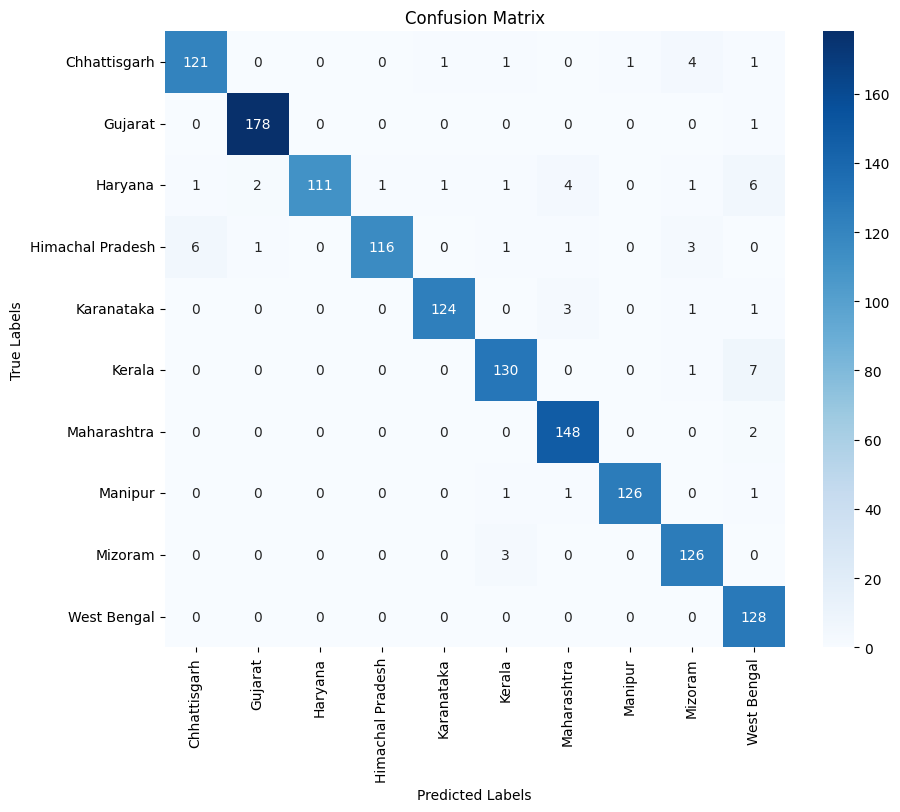

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

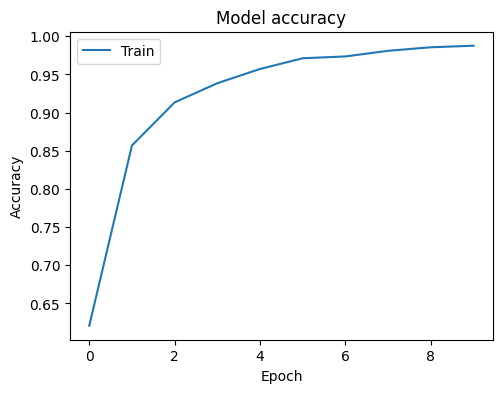

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

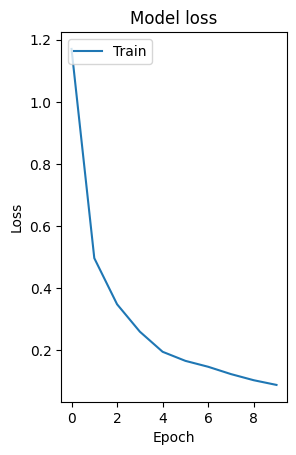

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/VGG16.h5')

# Define the preprocessing function
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

# Load and preprocess the image
img_path = '/content/drive/MyDrive/Dataset/Test11/Ke_4_34_11zon.jpg'
img_array = preprocess_image(img_path)

# Predict the spice
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Manually define class indices
class_indices = {
    0: 'Chhattisgarh',
    1: 'Gujarat',
    2: 'Haryana',
    3: 'Himachal Pradesh',
    4: 'Karanataka',
    5: 'Kerala',
    6: 'Maharashtra',
    7: 'Manipur',
    8: 'Mizoram',
    9: 'West Bengal'
    # Add other classes here in the correct order
}

# Map the predicted class index to the state name
predicted_state = class_indices[predicted_class]

print(f'The predicted state is: {predicted_state}')

1/1 [==============================] - 1s 726ms/step
The predicted state is: West Bengal


1/1 [==============================] - 1s 683ms/step


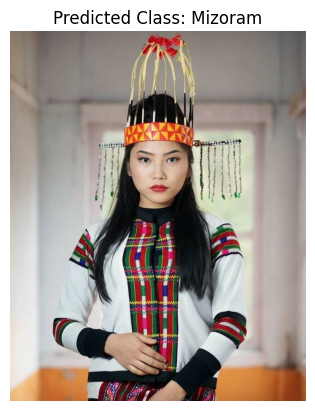

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Dataset/VGG16.h5')

# Define the class labels (Ensure these match the classes from your training data)
class_labels = ['Chhattisgarh', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Karanataka', 'Kerala', 'Maharashtra', 'Manipur', 'Mizoram', 'West Bengal']  # Replace with your actual class names

# Function to load and preprocess an image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to classify the image
def classify_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_labels[predicted_class_index]
    return predicted_class_name

# Function to display the image with the predicted class name
def display_image_with_prediction(img_path):
    predicted_class_name = classify_image(img_path)
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class_name}')
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/Dataset/Test11/Miz_5_50_11zon.jpg'  # Replace with your image path
display_image_with_prediction(image_path)

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16

# Load your trained model or pretrained model
# Assuming you have trained your ResNet50V2 model for spice classification
model =VGG16(weights='imagenet')  # Replace with your actual trained model
test_score = [0.0, 0.95]  # Replace with your actual test scores

# Compile the model to avoid warning about compiled metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define model name directly
model_name = 'VGG16'
subject = 'State Wise Costume Image Classification'
acc = test_score[1] * 100  # Assuming test_score[1] is the accuracy
save_path = '/content/drive/MyDrive/Dataset'  # Specify your desired save path

# Create the filename for saving the model
save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.keras'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Create the filename for saving the weights
weight_save_id = f'{model_name}-{subject}-weights.keras'
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

553467096/553467096 [==============================] - 4s 0us/step
model was saved as /content/drive/MyDrive/Dataset/VGG16-State Wise Costume Image Classification-95.00.keras
weights were saved as /content/drive/MyDrive/Dataset/VGG16-State Wise Costume Image Classification-weights.keras
